# NASA Turbofan dataset challenge

**Kaggle version of the very well known public data set for asset degradation modeling from NASA. It includes Run-to-Failure simulated data from turbo fan jet engines.**

### Prediction goal

**In this dataset the goal is to predict the remaining useful life (RUL) of each engine in the test dataset. 
RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset.**

### Experimental scenario

**Datasets consist of multiple multivariate time series. Time series data is is extracted from a engines of the same type. There are 22 sensor variables extracted from the engine with three operational settings. The engine is operating normally at the start of each time series and starts to degrade at some point during the series. Hence , Predict the remaining useful life (RUL) of the engines for every operational cycle.**


### Datasets

**Training set : the fault grows in magnitude until system failure. 
Testing set : time series ends some time prior to system failure.**

### Dataset description 

**The data are provided as a zip-compressed text file with 27 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:**
1) unit number 

2) time, in cycles

3) operational setting 1

4) operational setting 2

5) operational setting 3

6) sensor measurement 1

7) sensor measurement 2

…
27) sensor measurement 22

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost
import catboost
plt.rcParams['figure.figsize'] = 20, 20

C:\Users\peesri\Anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Each row is a snapshot of data taken during a single operational cycle
#No time information given so we don't know operational cycle time and its sampling frequency

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
directory = 'C:/Work/Machine_learning_projects/Data/PdM/data/NASA turbofan/CMaps/'
train_df = pd.read_csv(directory+r'\train_FD003.txt', 
                     sep='\s+', 
                     header=None,
                     index_col=False,
                     names=col_names)
train = train_df.copy()
test_df = pd.read_csv(directory+r'\test_FD003.txt', 
                     sep='\s+', 
                     header=None,
                     index_col=False,
                     names=col_names)
test = test_df.copy()
y_test = pd.read_csv(directory+r'\RUL_FD003.txt', 
                      sep='\s+', 
                      header=None,
                      index_col=False,
                      names=['RUL'])

In [85]:
train_df

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753


In [4]:
#remaining useful life is grouped by unit no
# there are 100 unit nos. so each unit no. has a different R2F cycle time

# RUL_by_unit = R2F_by_unit - current_operational_cycle_no

def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by='unit_number') 
    max_cycle = grouped_by_unit['time_cycles'].max() 
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), 
                            left_on='unit_number',
                            right_index=True)
    # Calculate remaining useful life for each row 
    remaining_useful_life = result_frame['max_cycle'] - result_frame['time_cycles']
    result_frame['RUL'] = remaining_useful_life 
    # drop max_cycle as it's no longer needed 
    result_frame = result_frame.drop("max_cycle", axis=1) 
    return result_frame

In [5]:
train = add_remaining_useful_life(train)
test = add_remaining_useful_life(test)

In [6]:
train.iloc[:,5:].head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


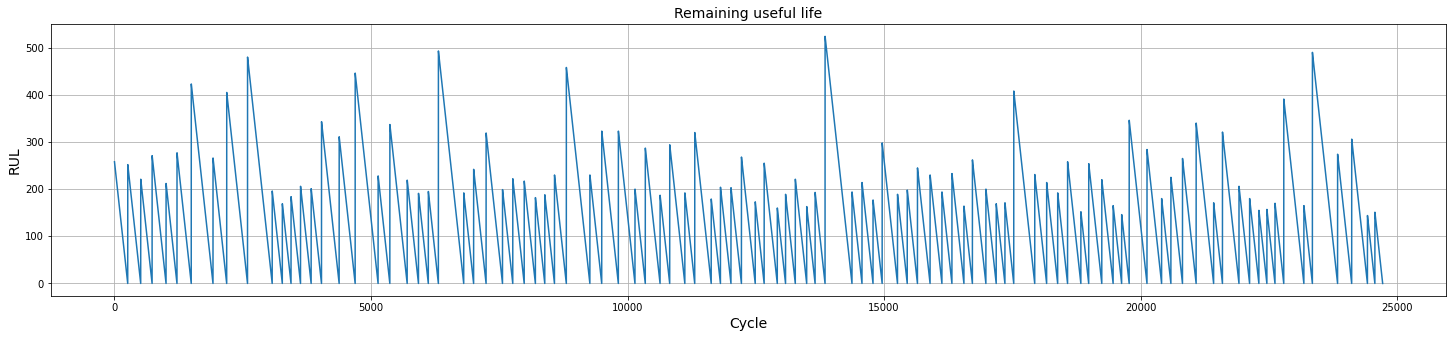

In [75]:
plt.figure(figsize=(25,5))
plt.plot(np.arange(0,len(train)),train['RUL'])
plt.xlabel('Cycle',fontsize=14)
plt.ylabel('RUL',fontsize=14)
plt.title('Remaining useful life',fontsize=14)
plt.grid()
plt.show()

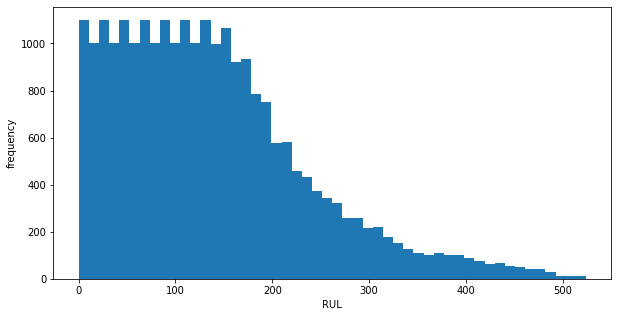

In [43]:
plt.figure(figsize=(10,5))
plt.hist(train['RUL'],bins=50)
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

#histogrm of RUL looks like a log-normal distribution function

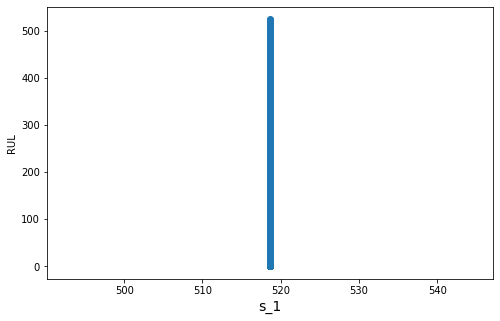

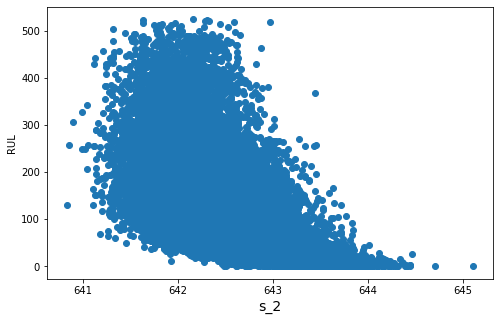

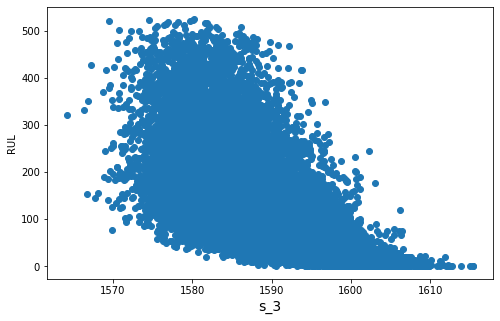

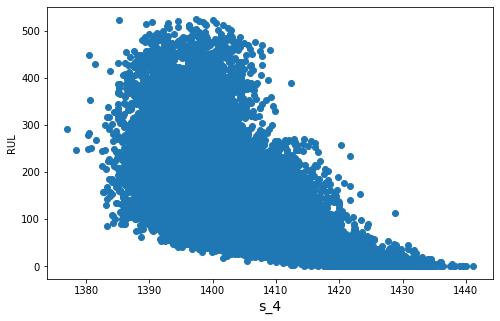

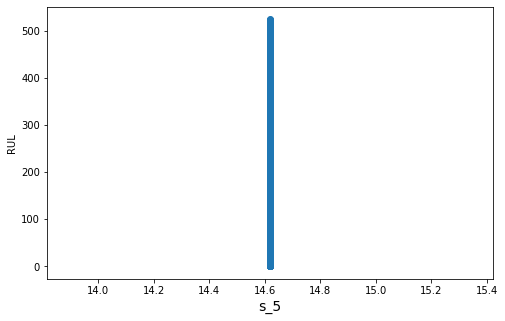

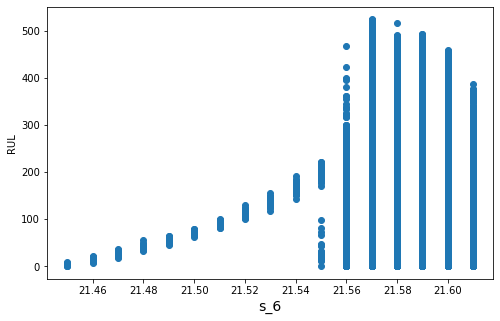

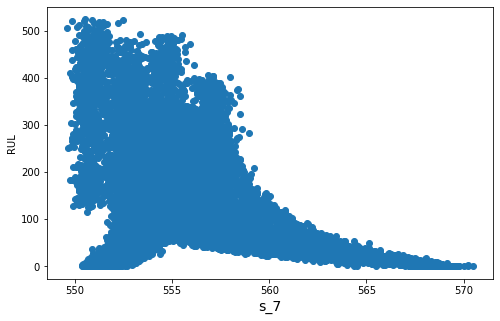

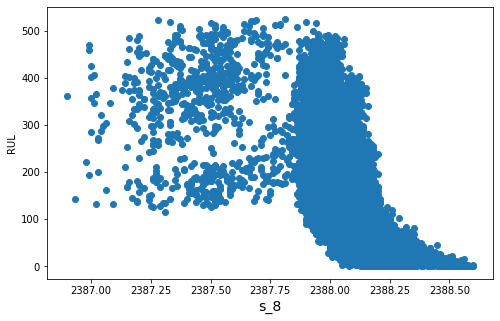

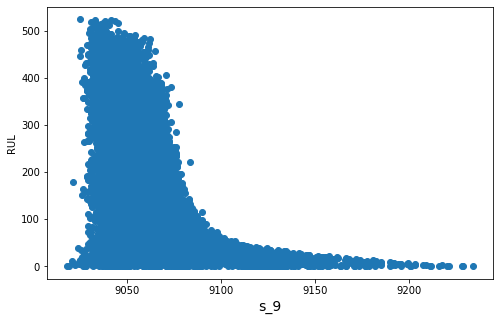

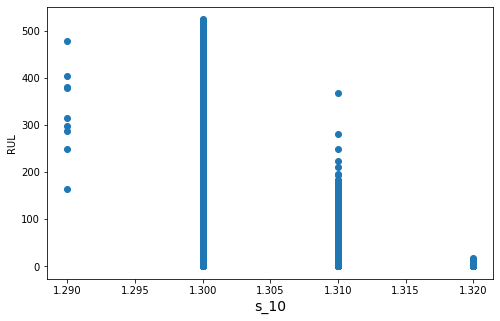

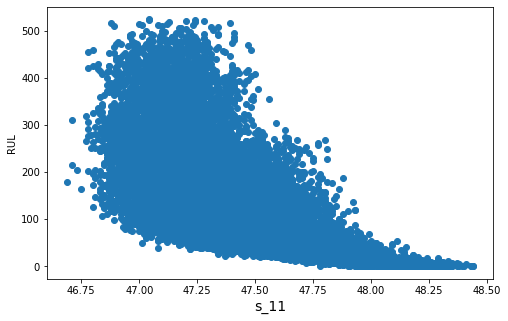

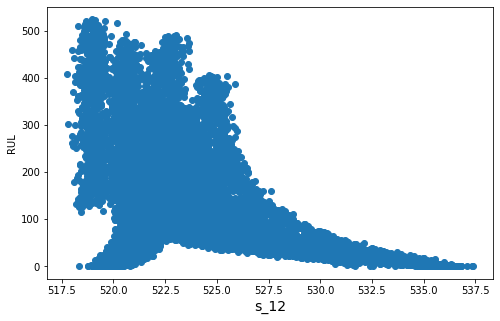

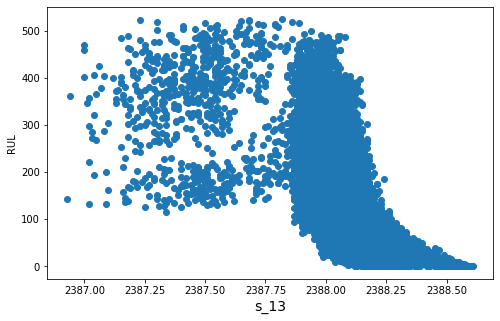

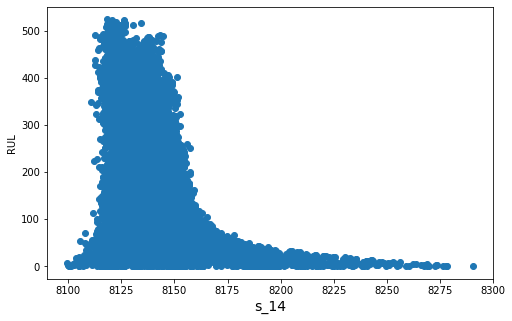

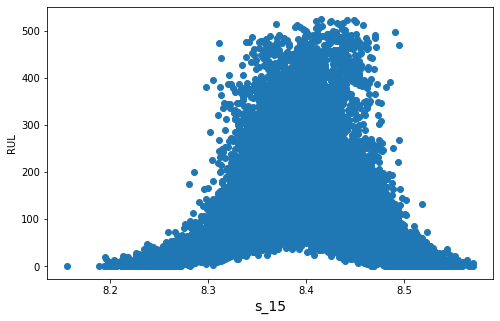

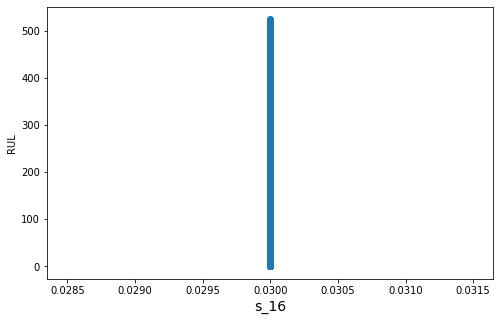

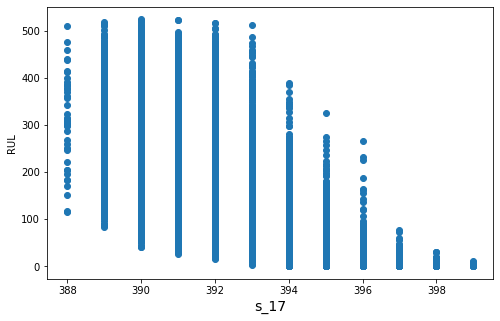

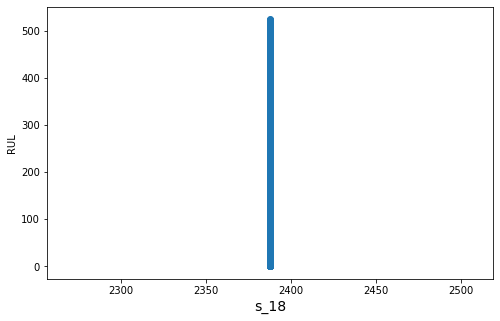

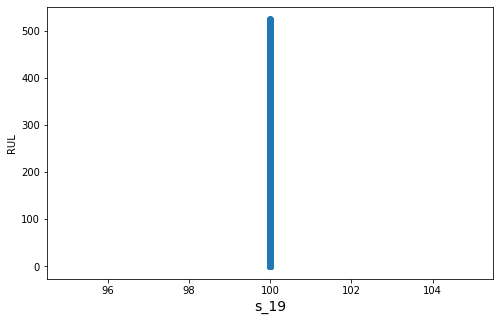

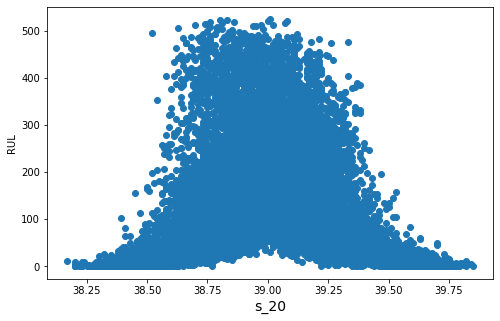

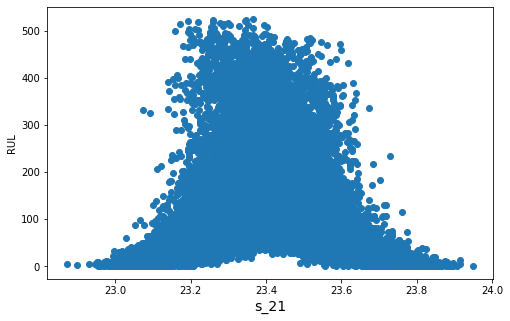

In [76]:
# plotting RUL vs sensor signal data

for cols in train.columns[5:-1]:
    plt.figure(figsize=(8,5))
    plt.scatter(train[cols],train['RUL'])
    plt.xlabel(cols, fontsize=14)
    plt.ylabel('RUL')
    plt.show()

<AxesSubplot:>

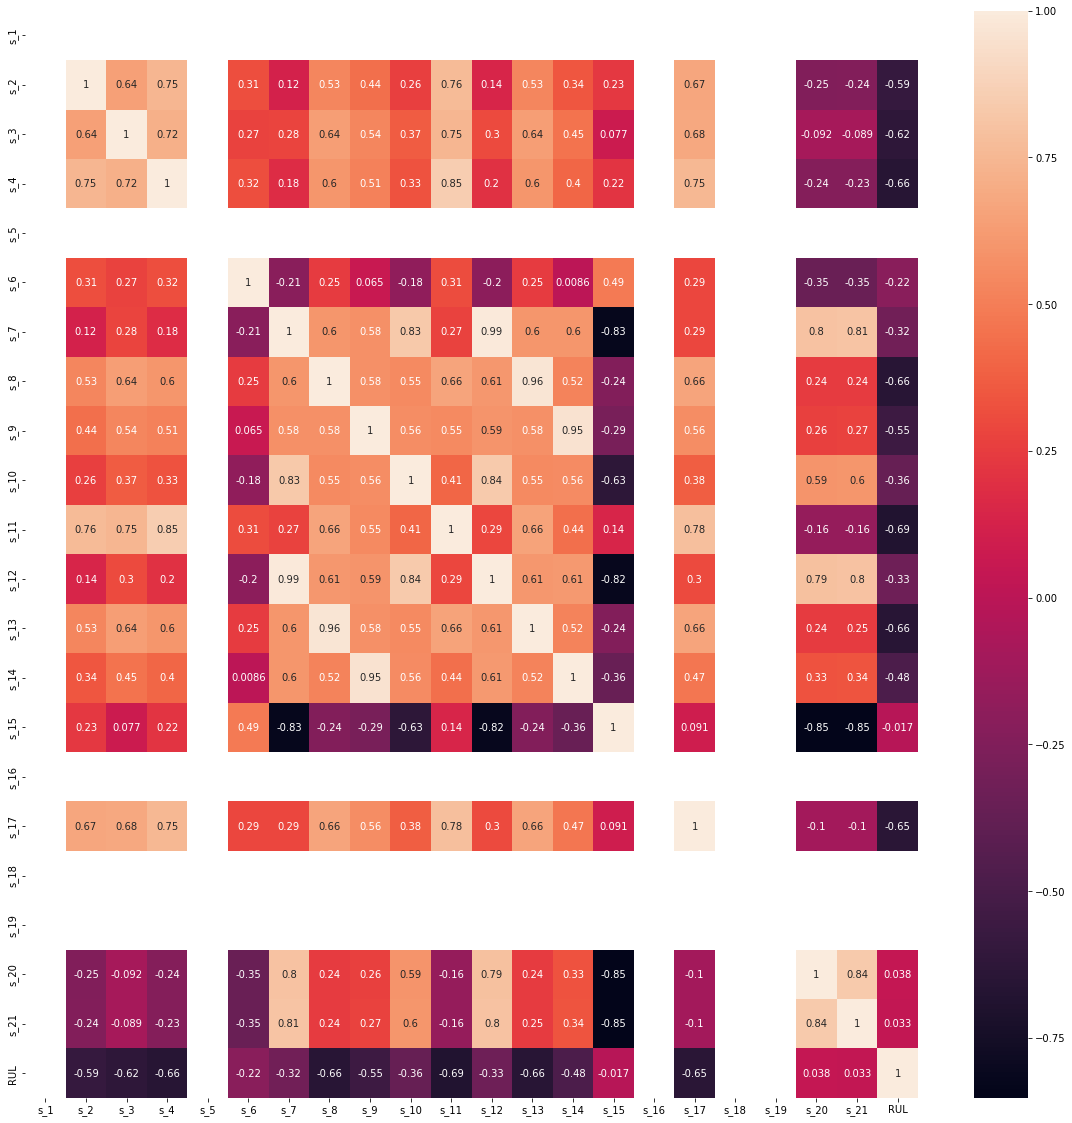

In [62]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr().iloc[5:,5:], annot=True)

#There are some weak to moderate correlations between sensors and RUL

In [7]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [8]:
X_train = train.iloc[:,5:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,5:-1]
y_test = test.iloc[:,-1]

In [9]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train, y_train)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.075686924717434, R2:0.9545371233623917
test set RMSE:103.18631193534473, R2:-0.535030314310083


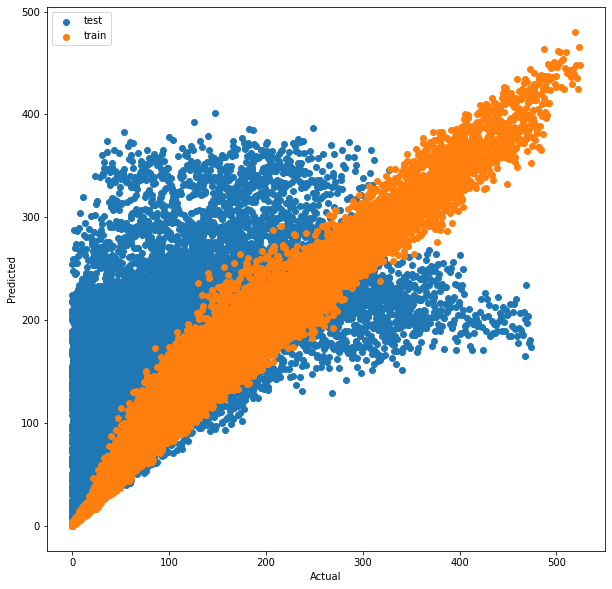

In [64]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,y_hat_test,label='test')
plt.scatter(y_train,y_hat_train,label='train')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

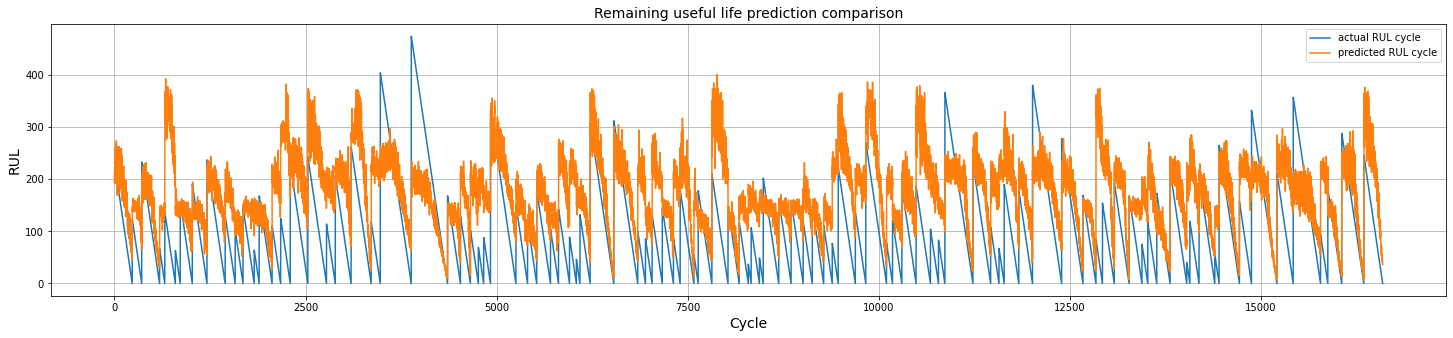

In [85]:
plt.figure(figsize=(25,5))
plt.plot(np.arange(0,len(y_test)),y_test,label='actual RUL cycle')
plt.plot(np.arange(0,len(y_hat_test)),y_hat_test,label='predicted RUL cycle')
plt.xlabel('Cycle',fontsize=14)
plt.ylabel('RUL',fontsize=14)
plt.title('Remaining useful life prediction comparison',fontsize=14)
plt.grid()
plt.legend()
plt.show()

# Neural Survival analysis

In [10]:
from pysurvival.models.multi_task import NeuralMultiTaskModel
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import create_risk_groups
from pysurvival.utils import save_model
from sklearn.preprocessing import normalize

In [11]:
X_train_normalized = normalize(X_train)
X_test_normalized = normalize(X_test)

In [12]:
#adding an event indicator column
#event indicator is 0 or 1. 
#1 indicates failure occured

train.loc[np.array(train[train['time_cycles']==1].index-1)[1:],'Event_ind'] = 1
train = train.fillna(0)
event_train = train.iloc[:,-1]
train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,Event_ind
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258,0.0
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257,0.0
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256,0.0
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255,0.0
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254,0.0


In [17]:
test.loc[np.array(test[test['time_cycles']==1].index-1)[1:],'Event_ind'] = 1
test = test.fillna(0)
event_test = test.iloc[:,-1]

In [37]:
neural_mltr = NeuralMultiTaskModel(structure = [ {'activation': 'ReLU', 'num_units': 128}, ],bins=np.max(train['time_cycles']),auto_scaler=False)
neural_mltr.fit(X_train_normalized, y_train, event_train, init_method = 'glorot_uniform', optimizer ='adam',
    lr = 1e-3, num_epochs = 1000, dropout = 0.2, l2_reg=1e-2,
    l2_smooth=1e-2, batch_normalization=False, bn_and_dropout=False,
    verbose=True, extra_pct_time = 0.1, is_min_time_zero=True)

% Completion: 100%|***********************************************|Loss: 650.02


NeuralMultiTaskModel( Layer(1): activation = ReLU, units = 128 )

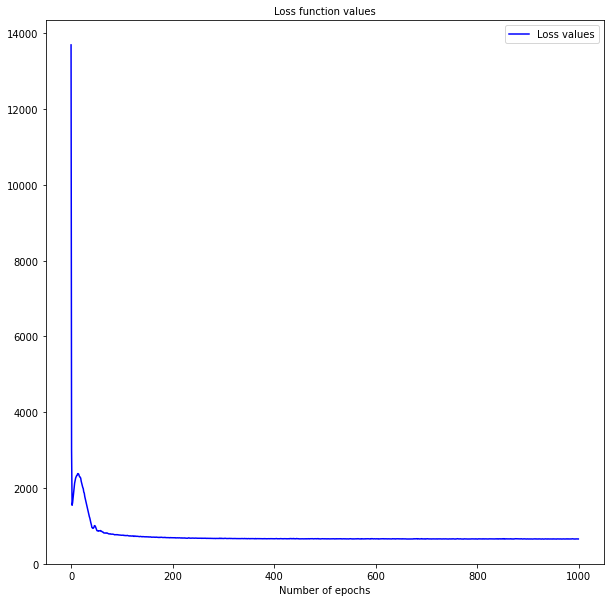

In [38]:
display_loss_values(neural_mltr, figure_size=(10, 10))

In [39]:
c_index = concordance_index(neural_mltr, X_test_normalized, y_test, event_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.74


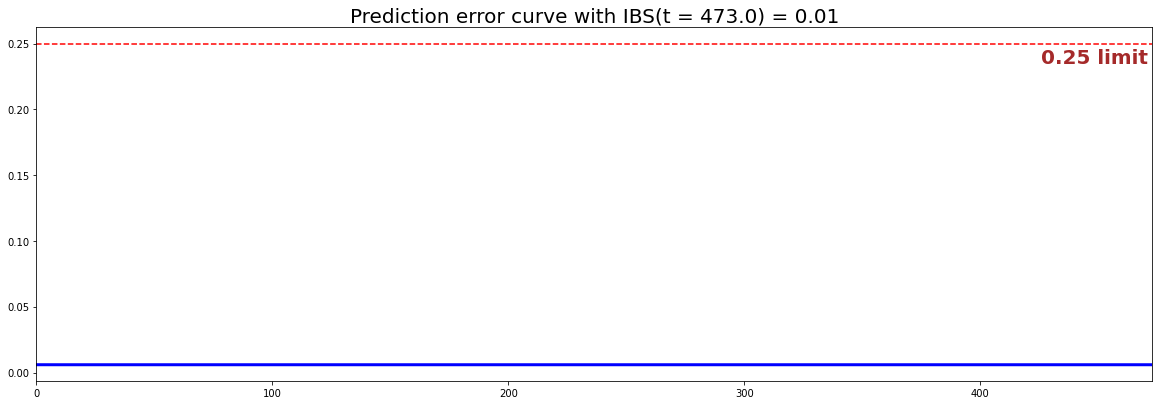

0.005935936831634108

In [40]:
integrated_brier_score(neural_mltr, X_test_normalized, y_test, event_test, figure_size=(20, 6.5) )

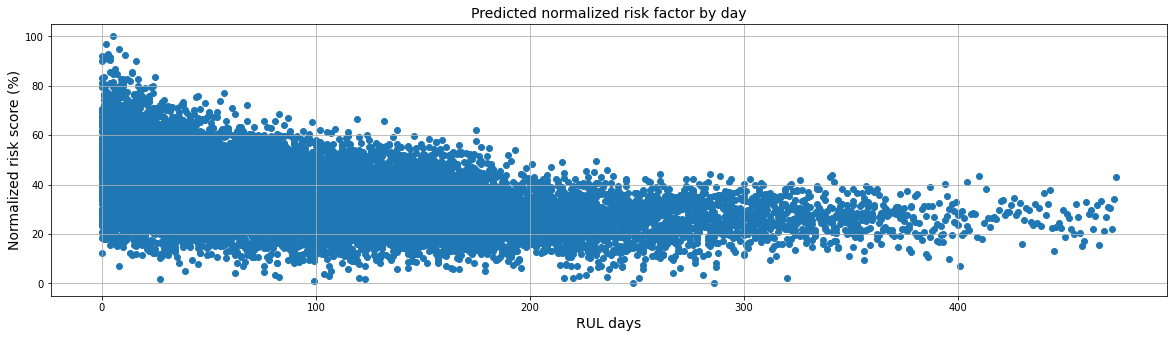

In [41]:
#compute risk score based on survival risk probabilities

risk = neural_mltr.predict_risk(X_test_normalized)
normalized_risk = (risk-min(risk))/(max(risk) - min(risk))
plt.figure(figsize=(20,5))
plt.scatter(y_test,normalized_risk*100)
#plt.xticks(np.arange(0, 474, 1.0))
plt.title('Predicted normalized risk factor by day',fontsize=14)
plt.xlabel('RUL days',fontsize=14)
plt.ylabel('Normalized risk score (%)',fontsize=14)
plt.grid()
plt.show()


#observe a downward trend
#As RUL decreases , the risk score increases. i.e. lower the remaining useful life, higher the risk score.

In [60]:
test_risk = pd.concat([test,pd.DataFrame(normalized_risk,columns=['risk_score'])],axis=1)

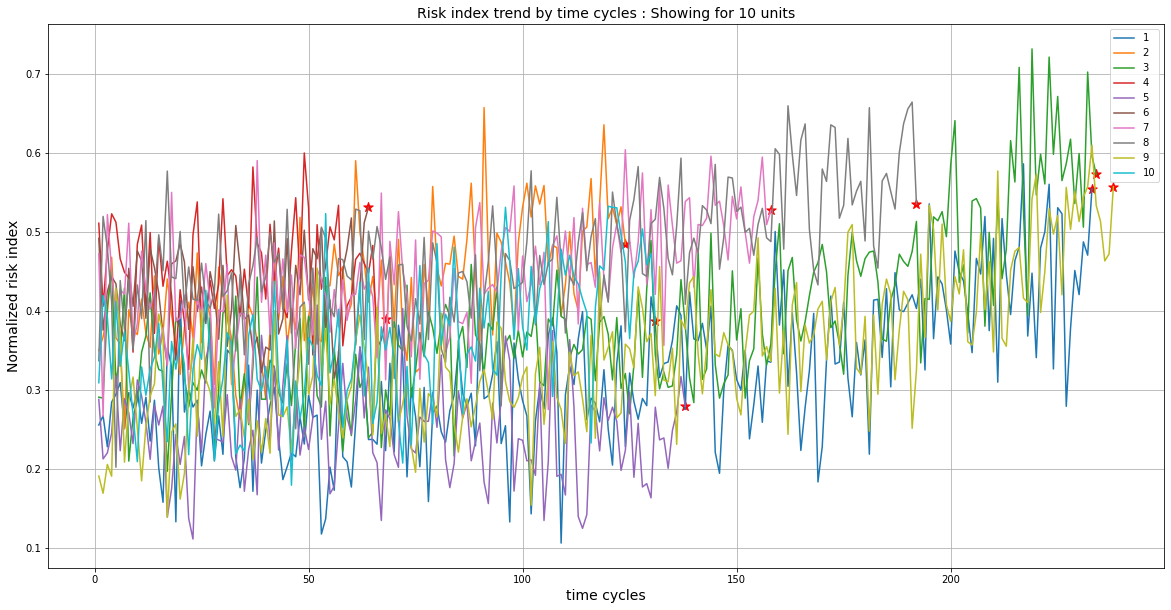

In [88]:
failure_index = np.array(test_risk[test_risk['Event_ind']==1].index)[0:10]
start = 0
plt.figure(figsize=(20,10))
for i in failure_index:  
    plt.plot(test_risk.loc[start:i,'time_cycles'],test_risk.loc[start:i,'risk_score'],label=test_risk.loc[start,'unit_number'])
    plt.scatter(test_risk.loc[i,'time_cycles'],test_risk.loc[i,'risk_score'],marker='*',s=100,c='r')
    start = i+1
plt.xlabel('time cycles',fontsize=14)
plt.ylabel('Normalized risk index',fontsize=14)
plt.grid()
plt.legend()
plt.title('Risk index trend by time cycles : Showing for 10 units',fontsize=14)
plt.show()

# conclusion

### We can use survival based analysis to compute a risk score, however, PySurvival package does not support prediction of RUL.

### Currently, we are using RUL days as our output labels directly, instead we need to use the neural network model to predict the shape of the survival density function. 

### Explore the usage of Deep time-to-failure model in https://github.com/gm-spacagna/deep-ttf This model uses gated recurrent units (GRU) to predict the shape of the survival function (modelled as weibull distribution) based on RUL. 